In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier

# Supervised Algorithms
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier

# Evaluation metrics
from sklearn.metrics import roc_auc_score, auc, plot_roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

## Scope of the challenge

The main idea behind this data challenge consists of detecting defective manufacturing components whose measured properties are not conformal to standards. The dataset used has been provided by the French automotive supplier Valeo.<br>

The task at hand is to develop an anomaly detection algorithm which associates an anomaly score to qualify a new observation as being abnormal, the higher the score, the more it qualifies as anomalous. We will mainly focus on a supervised approach since target variables are provided.<br>

In the following notebook, we start with an exploration phase to understand the data we have been provided with, we then show the performances of different supervised algorithms and lastly how we optimized the selected algorithm with specific features.


## I - Exploration Phase

In [2]:
# ---- Data import
X = pd.read_csv("xtrain.csv")
y = pd.read_csv("ytrain.csv")

# ---- DataFrame containing samples and their respective labels in the same structure
X_y = X.copy()
X_y['Anomaly'] = y['Anomaly']

# ---- Separation of normal and anomalous samples
X_normal = X_y[X_y['Anomaly'] == 0]
X_anomalous = X_y[X_y['Anomaly'] == 1]

# ---- Dataset for submission
X_submit = pd.read_csv("xtest.csv")

### a. Analysis of the shape of the data

In [3]:
X.head()

START2_OP020_V_1angle  START2_OP020_V_1torque  START2_OP020_V_2angle  \
0                   35.7                    3.76                   49.1   
1                   47.2                    3.77                   50.3   
2                   52.7                    3.78                   40.4   
3                   34.9                    3.77                   34.9   
4                   50.0                    3.77                   41.9   

   START2_OP020_V_2torque  START2_OP040_Vision_cosseprog  \
0                    3.78                          300.0   
1                    3.76                           30.0   
2                    3.78                          300.0   
3                    3.78                         1000.0   
4                    3.75                          400.0   

   START2_OP050_Vision_paliermodel  START2_OP050_Vision_palierpresencedouille  \
0                              1.0                                        1.0   
1                              1.0                                        1.0   
2                              1.0                                        1.0   
3                              2.0                                        1.0   
4                              1.0                                        1.0   

   START2_OP060_Vision_tirantcouleur  START2_OP070_V_1angle  \
0                                2.0                  111.7   
1                                2.0                  106.0   
2                                2.0                  103.4   
3                                1.0                  146.0   
4                                2.0                  115.8   

   START2_OP070_V_1prog  ...  START2_OP090_SnapRingFinalStroke  \
0                   8.0  ...                             11.60   
1                   8.0  ...                             11.82   
2                   8.0  ...                             11.86   
3                   7.0  ...                             11.47   
4                   8.0  ...                             11.88   

   START2_OP090_SnapRingMidPointForce  START2_OP090_SnapRingPeakForce  \
0                               71.52                          122.23   
1                               67.38                          163.78   
2                               89.09                          207.73   
3                               93.45                          177.31   
4                               85.17                          174.73   

   START2_OP090_StartLinePeakForce  START2_OP100_Capuchon_insertionmesure  \
0                            20.57                                   0.55   
1                            18.73                                   0.55   
2                            26.39                                   0.55   
3                            25.73                                   0.59   
4                            21.50                                   0.42   

   START2_OP110_Vissage_M8angle  START2_OP110_Vissage_M8prog  \
0                          34.7                          2.0   
1                          38.7                          2.0   
2                          30.2                          2.0   
3                          17.6                          1.0   
4                          52.0                          1.0   

   START2_OP110_Vissage_M8torque  START2_OP120_RodageI_mesure  \
0                           9.54                       126.96   
1                           9.54                       133.88   
2                           9.66                       135.28   
3                          12.06                       116.51   
4                          12.12                       140.92   

   START2_OP120_RodageU_mesure  
0                        11.97  
1                        11.97  
2                        11.97  
3                        11.97  
4                        11.98  

[5 rows x 27 columns]

In [4]:
print("The training sample has", X.shape[0], "samples and", X.shape[1], "features.")
print("The testing sample has", X_submit.shape[0], "samples and", X_submit.shape[1], "features.")
print("The target variable being either 0 or 1 if the sample is normal or anomalous respectively.")

The training sample has 27586 samples and 27 features.
The testing sample has 27587 samples and 27 features.
The target variable being either 0 or 1 if the sample is normal or anomalous respectively.


##### We verify whether there are any null values within the dataset.

*In the training set :*

In [5]:
X_y.isna().sum()

START2_OP020_V_1angle                        0
START2_OP020_V_1torque                       0
START2_OP020_V_2angle                        0
START2_OP020_V_2torque                       0
START2_OP040_Vision_cosseprog                0
START2_OP050_Vision_paliermodel              0
START2_OP050_Vision_palierpresencedouille    0
START2_OP060_Vision_tirantcouleur            0
START2_OP070_V_1angle                        0
START2_OP070_V_1prog                         0
START2_OP070_V_1torque                       0
START2_OP070_V_2angle                        0
START2_OP070_V_2prog                         0
START2_OP070_V_2torque                       0
START2_OP080_Vision_rondelleprog             0
START2_OP090_MaxMidForceLimit                0
START2_OP090_MinMidForceLimit                0
START2_OP090_SnapRingFinalStroke             0
START2_OP090_SnapRingMidPointForce           0
START2_OP090_SnapRingPeakForce               0
START2_OP090_StartLinePeakForce              0
START2_OP100_

*In the test set :*

In [6]:
X_submit.isna().sum()

START2_OP020_V_1angle                        0
START2_OP020_V_1torque                       0
START2_OP020_V_2angle                        0
START2_OP020_V_2torque                       0
START2_OP040_Vision_cosseprog                0
START2_OP050_Vision_paliermodel              0
START2_OP050_Vision_palierpresencedouille    0
START2_OP060_Vision_tirantcouleur            0
START2_OP070_V_1angle                        0
START2_OP070_V_1prog                         0
START2_OP070_V_1torque                       0
START2_OP070_V_2angle                        0
START2_OP070_V_2prog                         0
START2_OP070_V_2torque                       0
START2_OP080_Vision_rondelleprog             0
START2_OP090_MaxMidForceLimit                0
START2_OP090_MinMidForceLimit                0
START2_OP090_SnapRingFinalStroke             0
START2_OP090_SnapRingMidPointForce           0
START2_OP090_SnapRingPeakForce               0
START2_OP090_StartLinePeakForce              0
START2_OP100_

<b> Thus there are no null values in the dataset.

In [7]:
X.dtypes.value_counts()

float64    27
dtype: int64

<b> All values are floats.

### b. Analysis of the target variable

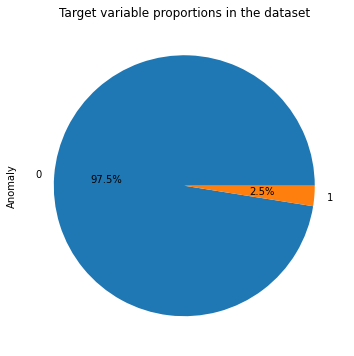

In [8]:
y['Anomaly'].value_counts().plot.pie(normalize=True, autopct='%1.1f%%', figsize=(8,6), title="Target variable proportions in the dataset")
plt.show()

In [9]:
y["Anomaly"].value_counts()

0    26893
1      693
Name: Anomaly, dtype: int64

<b> We can clearly see that we have an imbalanced dataset with 97.5% of normal samples versus 2.5% of anomalous samples; 26893 of the first and 693 of the latter.

### c. Analysis of duplicates

In [10]:
y.loc[X[X.duplicated(keep=False)].index, 'Anomaly'].value_counts()

0    331
1    323
Name: Anomaly, dtype: int64

<b>This suggests that there are 331 duplicated rows within normal observations and 323 duplicated rows within anomalous observations.


In [11]:
print(f"We can therefore say that {331/y[y['Anomaly'] == 0].shape[0]*100:.2f} % of normal observations are duplicated.")
print(f"And {323/y[y['Anomaly'] == 1].shape[0]*100:.2f} % of anomalous observations are duplicated.")

We can therefore say that 1.23 % of normal observations are duplicated.
And 46.61 % of anomalous observations are duplicated.


**We can interpret this as:** <br>
    <li> When an anomalous component is created in the production chain, it is consistent and may come from the same errors in the manufacturing process. 
    <li> The data was artificially generated. <br>
This information is important and may be used later on.

### d. Distribution of features with respect to the target variable ('Anomaly' = 0 or 1).

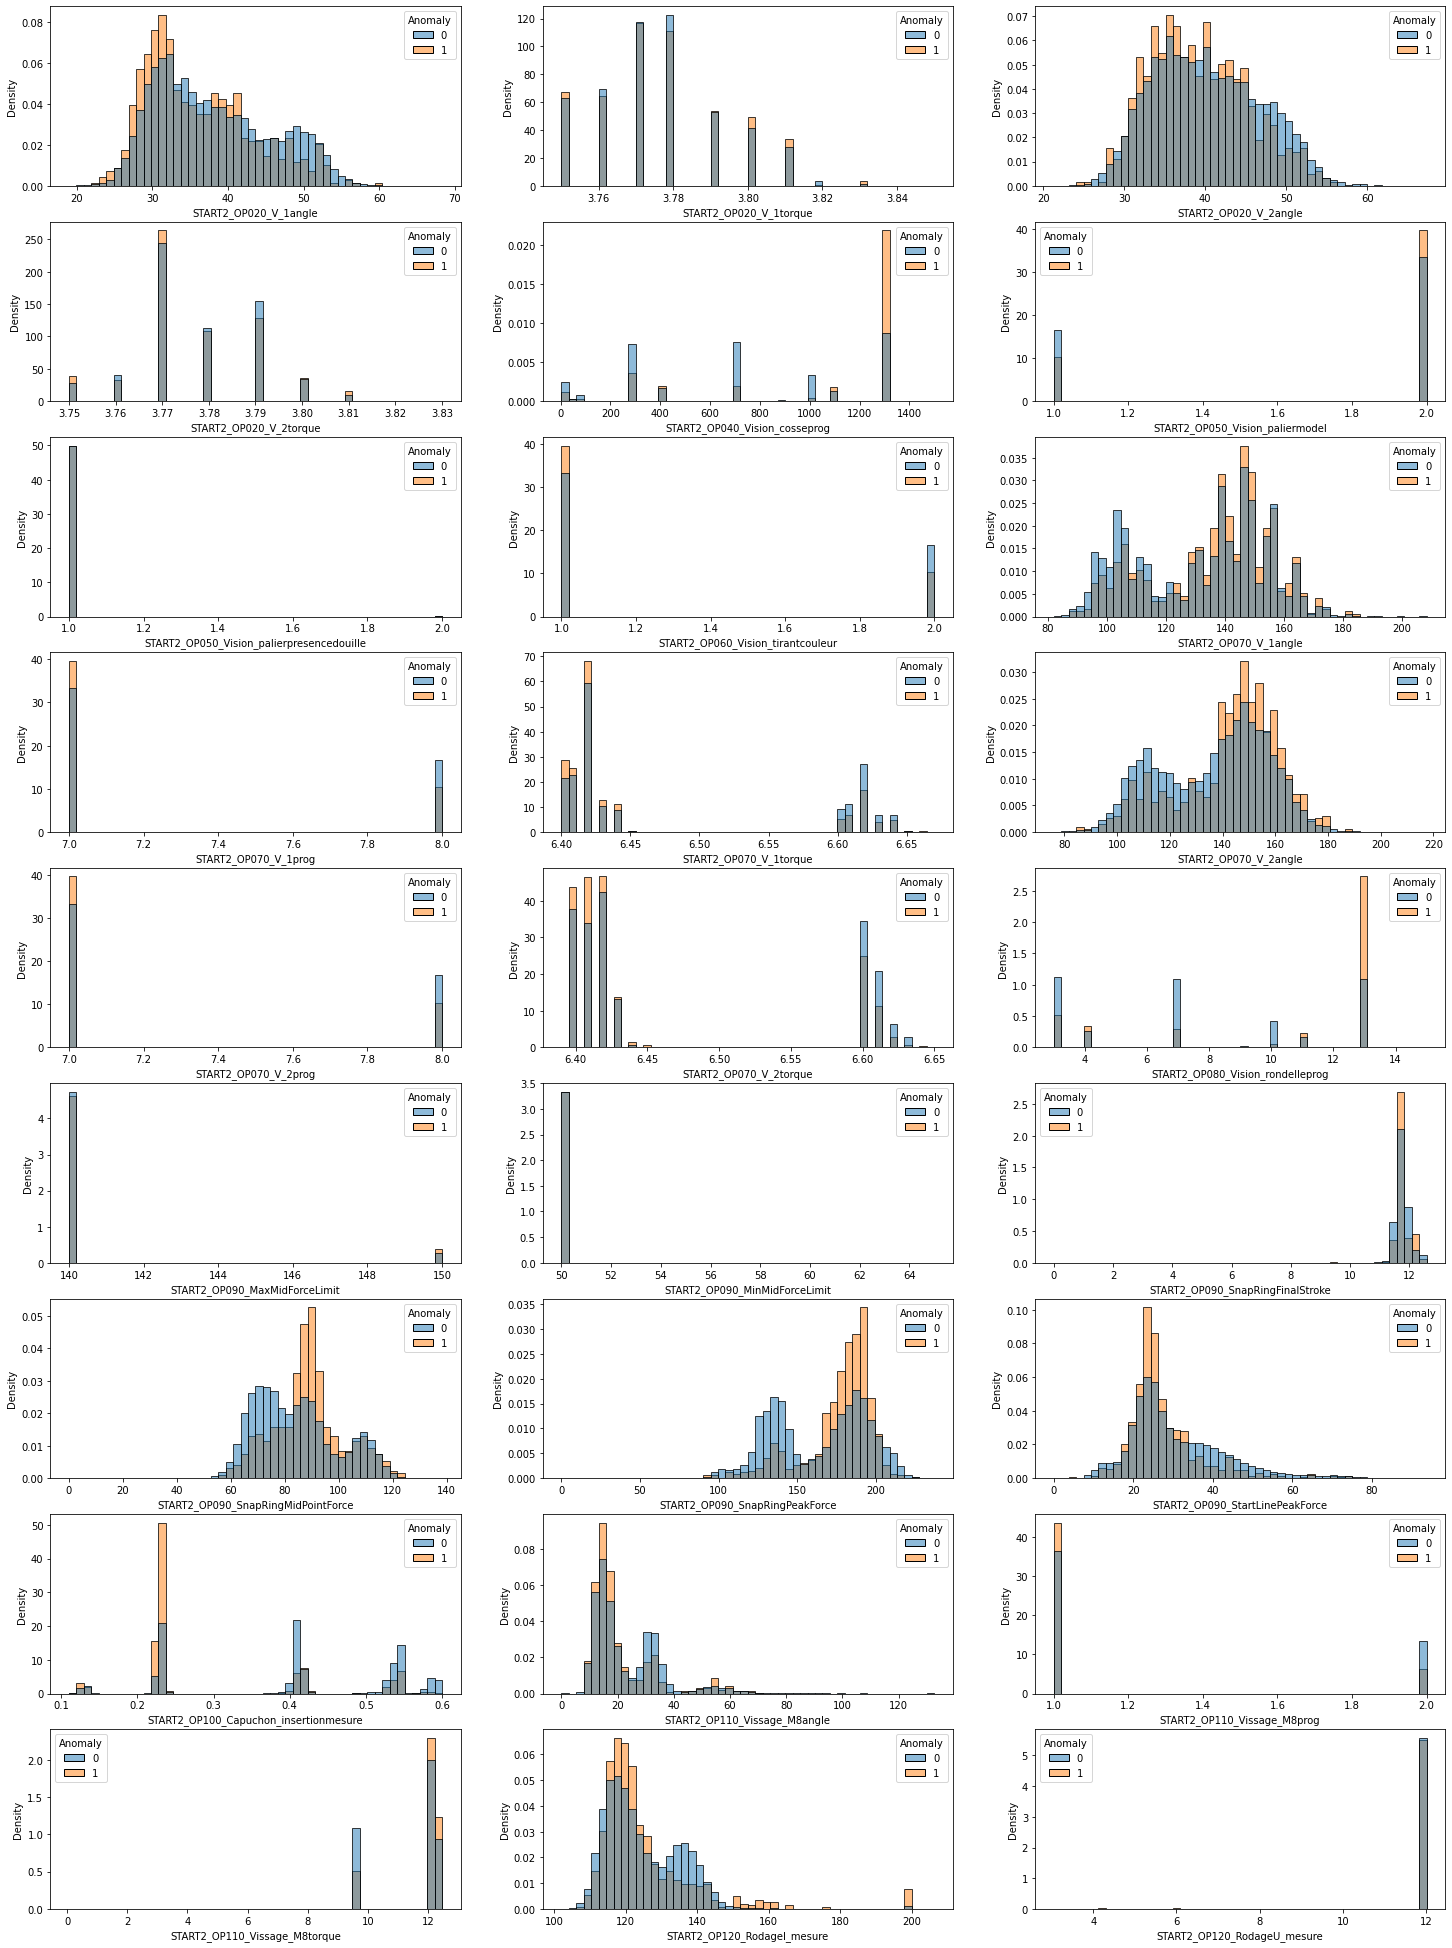

In [12]:
i = 1
plt.figure(figsize=(25, 35))
for feature in X.columns:
    plt.subplot(9, 3, i)
    sns.histplot(data = X_y, x = feature, hue = 'Anomaly', stat = 'density', common_norm = False, bins = 50)
    #sns.kdeplot(data = X_y, x = feature, hue = 'Anomaly', common_norm=False, fill=False)
    i += 1
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


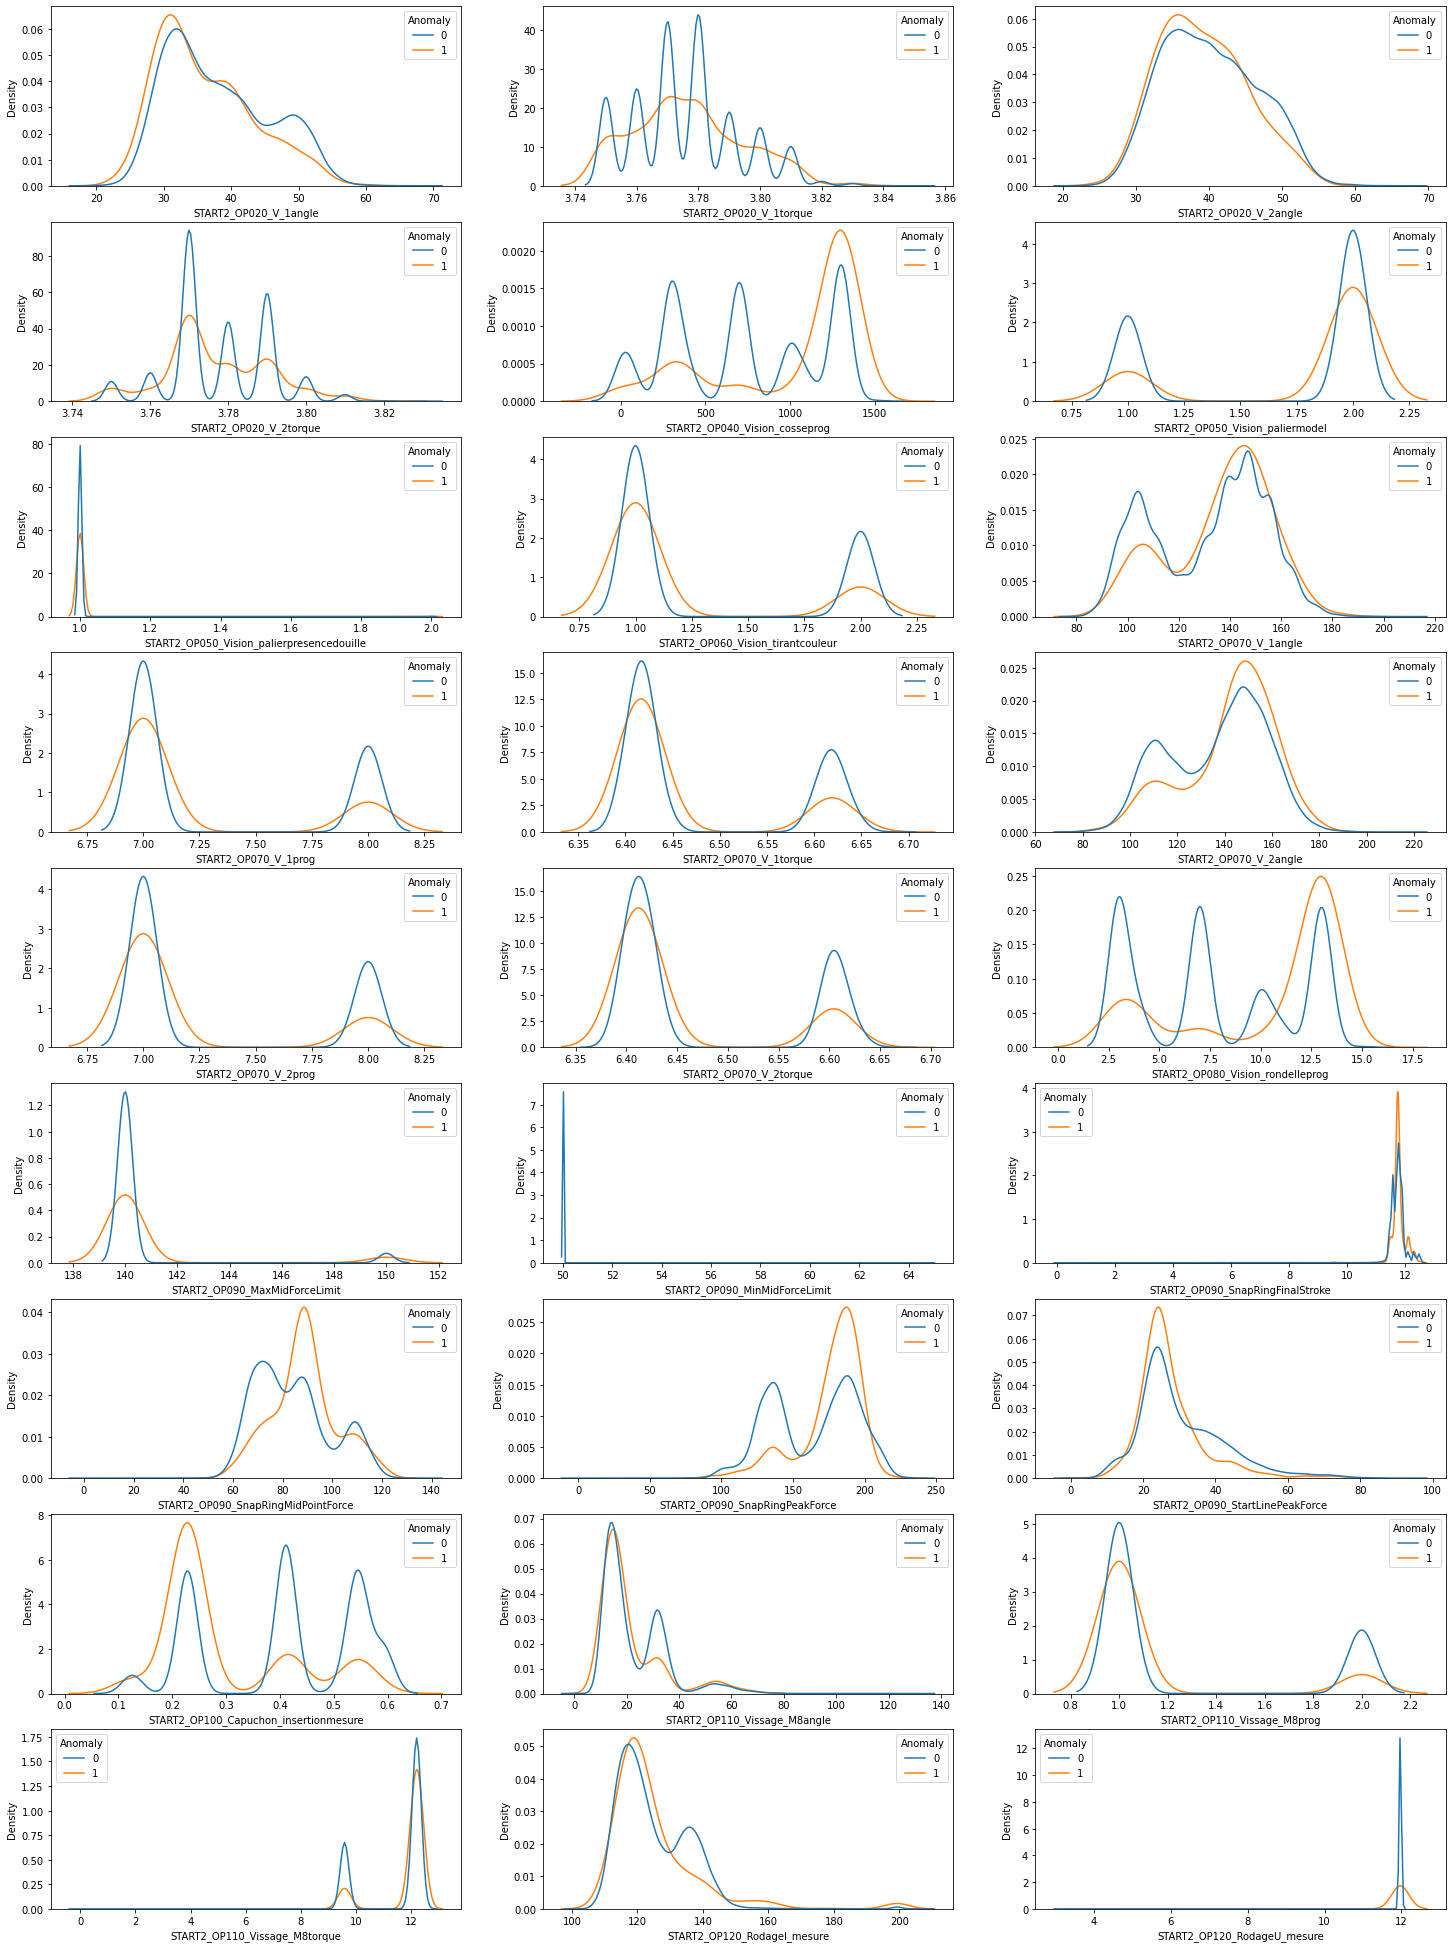

In [13]:
i = 1
plt.figure(figsize=(25, 35))
for feature in X.columns:
    plt.subplot(9, 3, i)
    #sns.histplot(data = X_y, x = feature, hue = 'Anomaly', stat = 'density', common_norm = False, bins = 50, kde = True)
    sns.kdeplot(data = X_y, x = feature, hue = 'Anomaly', common_norm=False, fill=False)
    i += 1
plt.show()

#### First impressions on the data:

- There are both **categorical and continuous features.**
- Some features follow a **bi-modal or multi-modal distribution.**
- The **distributions of features are very similar** but there are some small differences for the following ones:
    - START2_OP020_V_1torque
    - START2_OP020_V_2torque
    - START2_OP040_Vision_cosseprog
    - START2_OP080_Vision_rondelleprog
    - START2_OP090_SnapRingMidPointForce as the most notable difference in distribution
    - START2_OP090_StartLinePeakForce
    - START2_OP100_Capuchon_insertionmesure
    - START2_OP120_RodageI_mesure
    
<b>It seems that there is no specific feature distribution that allows us to strongly discriminate anomalous and normal observations.<b>

### e. Distribution of features between each other

We have found in the previous section, that there are both continuous and categorical features.<br>
The following method allows us to separate categorical features from continuous ones.

In [14]:
def separate_feature_types(df, threshold):
    
    """
    Selects categorical and continuous features from a DataFrame.
    The selection is based on the number of distinct values set by the threshold.
    
    Example: If a feature has less than 100 disctinct values, it will be considered as a categorical feature.
    
    Parameters:
    -----------
    df : pd.DataFrame
    threshold: int
    
    Returns:
    --------
    categorical_features: list
    continuous_features: list
    """
    
    categorical_features = []
    continuous_features = []

    for col_name in X.columns:
        if len(X[col_name].unique()) < threshold: 
            categorical_features.append(col_name)
        else :
            continuous_features.append(col_name)
    
    return categorical_features, continuous_features

threshold = 90
categorical_features, continuous_features = separate_feature_types(X, threshold)

#### Analysis of continuous features

We use an undersampled dataset because the normal observations will cover the outnumbered anomalous observations in the scatterplots.

In [15]:
preprocess = ColumnTransformer([
            ('std', StandardScaler(), continuous_features)
            ], remainder='passthrough')

In [16]:
# ---- Undersampled dataset containing less normal samples, this will facilitate visualization
X_y_undersampled = pd.concat([X_normal.sample(n=3000), X_anomalous])

# ---- Standardizing continuous features
X_y_undersampled_std = pd.DataFrame(preprocess.fit_transform(X_y_undersampled), columns = continuous_features + categorical_features + ['Anomaly'])

Note : the code below may take time to load (approx 2 min)

[]

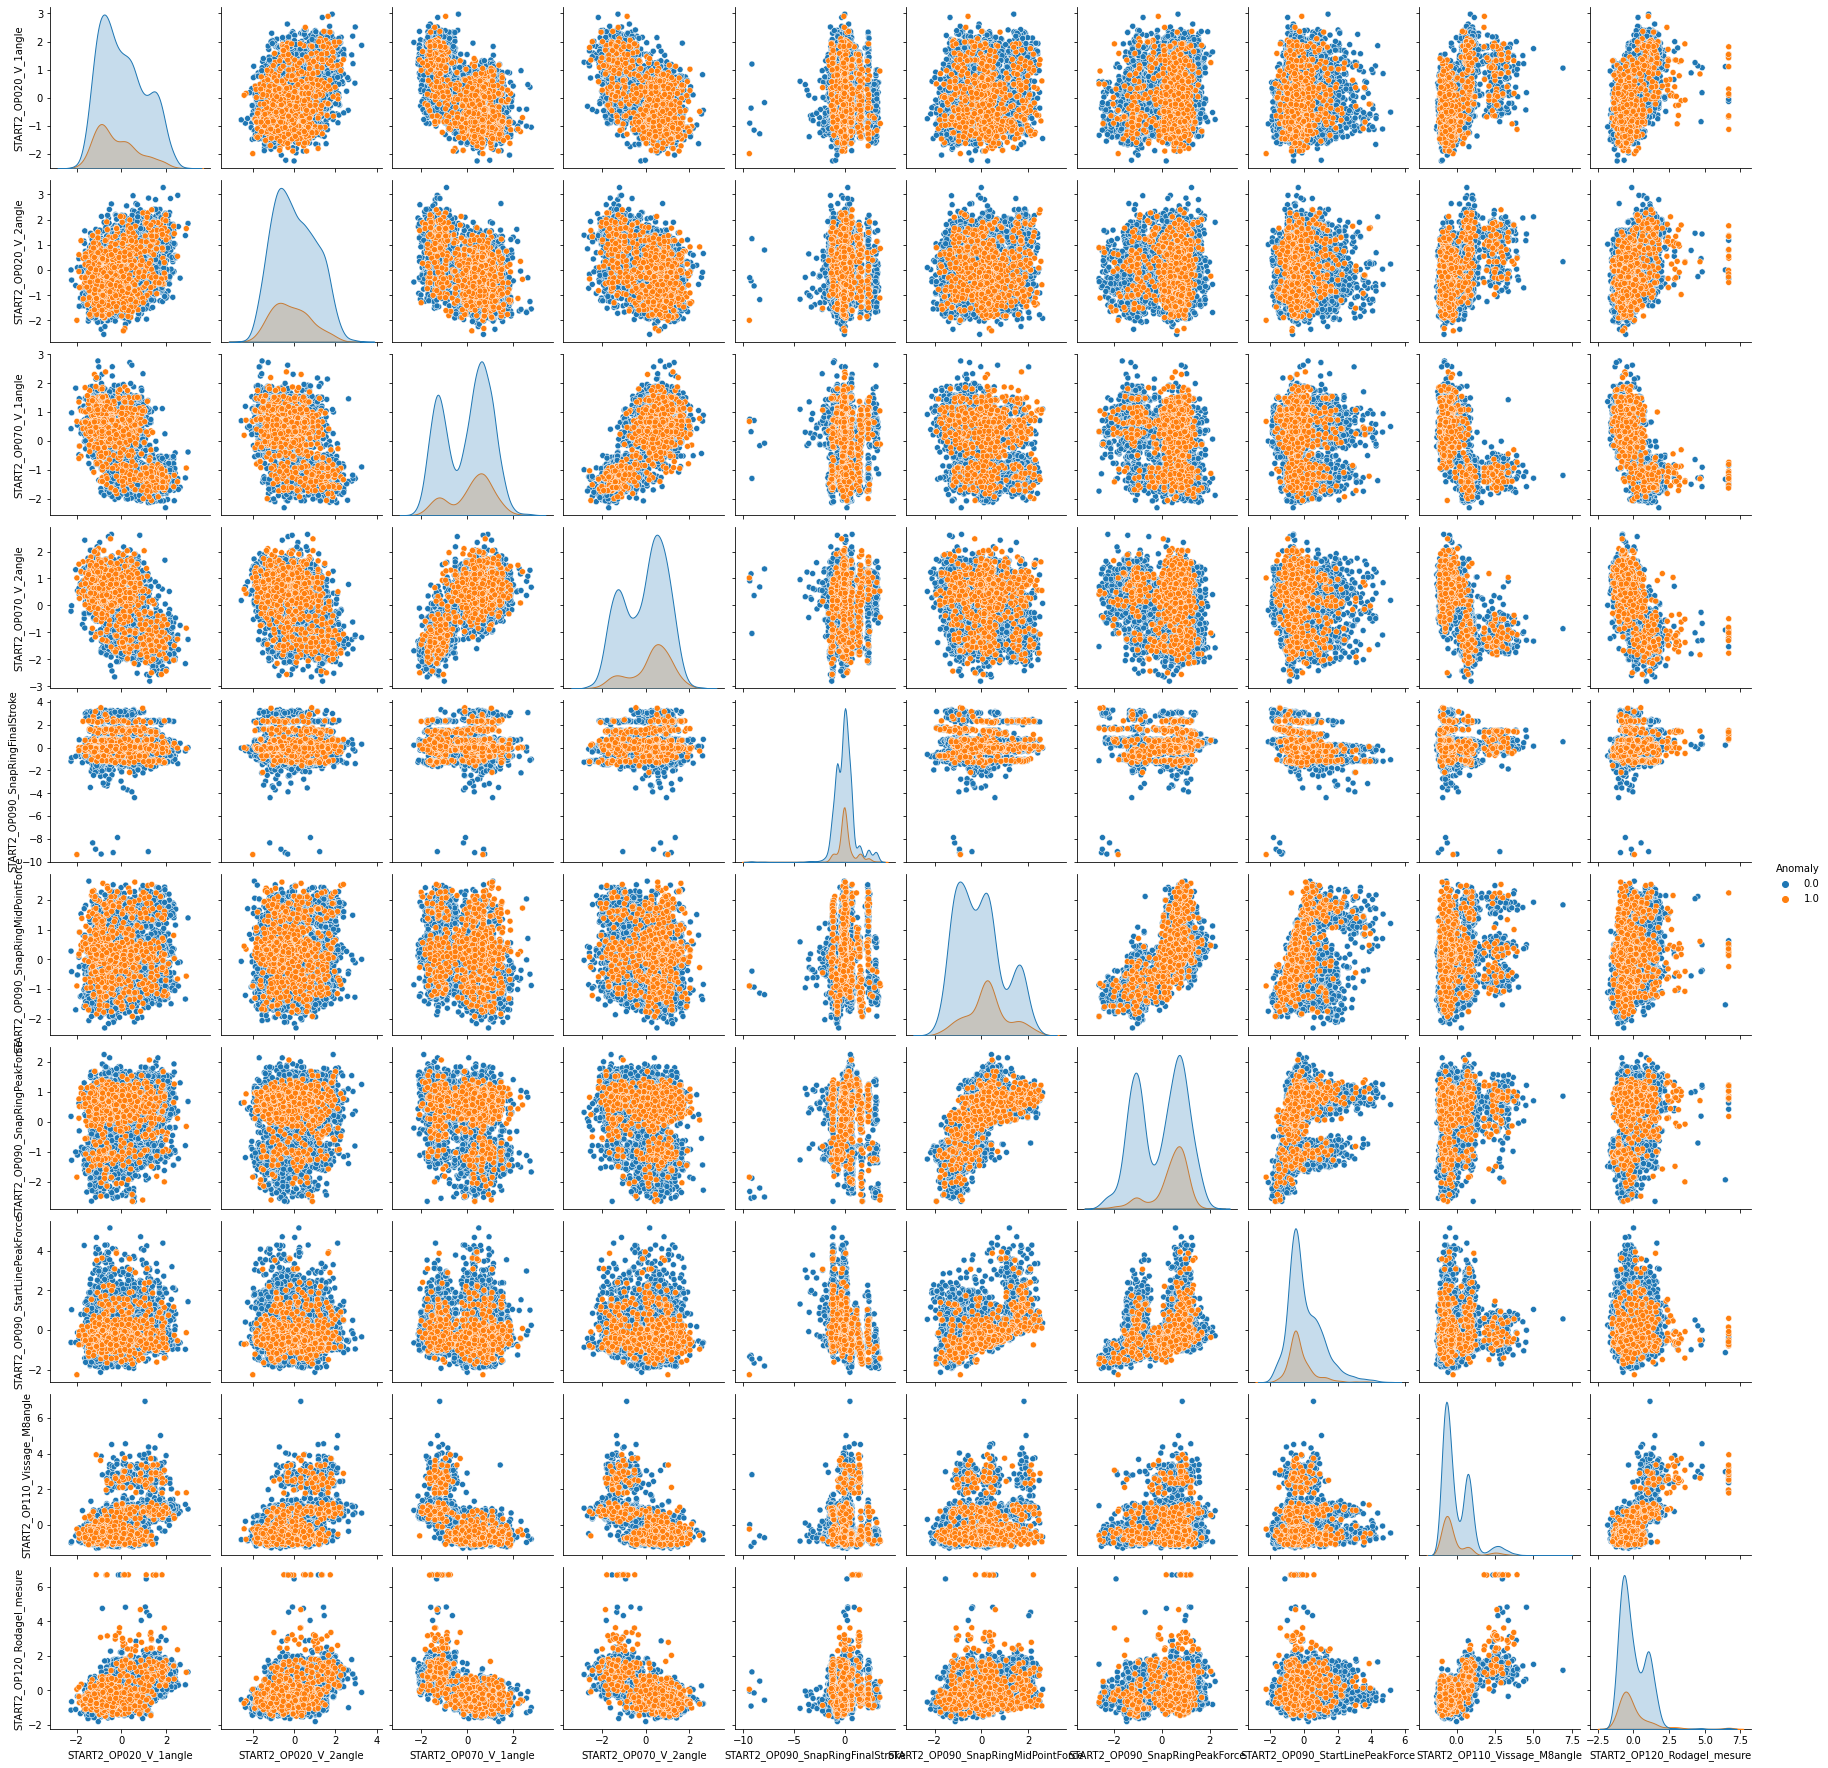

In [17]:
# ---- Plot only continuous features
sns.pairplot(X_y_undersampled_std[continuous_features + ['Anomaly']], hue='Anomaly')
plt.plot()

We arrive to the same conclusion as previously, it seems that **anomalous observations are not easy to discriminate from normal observations.**<br>
However, we can see that the feature START2_OP120_RodageI_mesure combined with other features brings out some anomalous observations.


#### Analysis of categorical features

Note : the code below may take time to load (approx 3 min)

In [18]:
# ---- Plot only categorical features
#sns.pairplot(X_y_undersampled[categorical_features + ['Anomaly']], hue='Anomaly')
#plt.plot()

Again, **there are no clusters that allow to visually distinguish anomalous observations from normal ones.** <br>
Even though the data visualization we have done so far is not exhaustive, it gives us an idea about how the data is spread. <br>
More specifically, we can deduce that **anomalous observations are clustered within normal observations** and therefore to train our model, **we will need to select features and possibly create others**.

Another approach that has been tested but not shown in this report for the sake of space and visibility, is to visualize features with the same ID code between each other and see if we are able to discriminate anomalous observations from normal observations (i.e all features with the code "OP020" or "OP100" for instance). <br>
Since we do not have information concerning what each feature represents from an industrial and manufacturing standpoint, this idea came by assuming that features with the same ID code are related, thus an anomalous value from one feature may impact another. Moreover, polynomial combinations of the features have been test, however, nothing was conclusive either. <br> 

Shown below is a sample code of the idea:

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


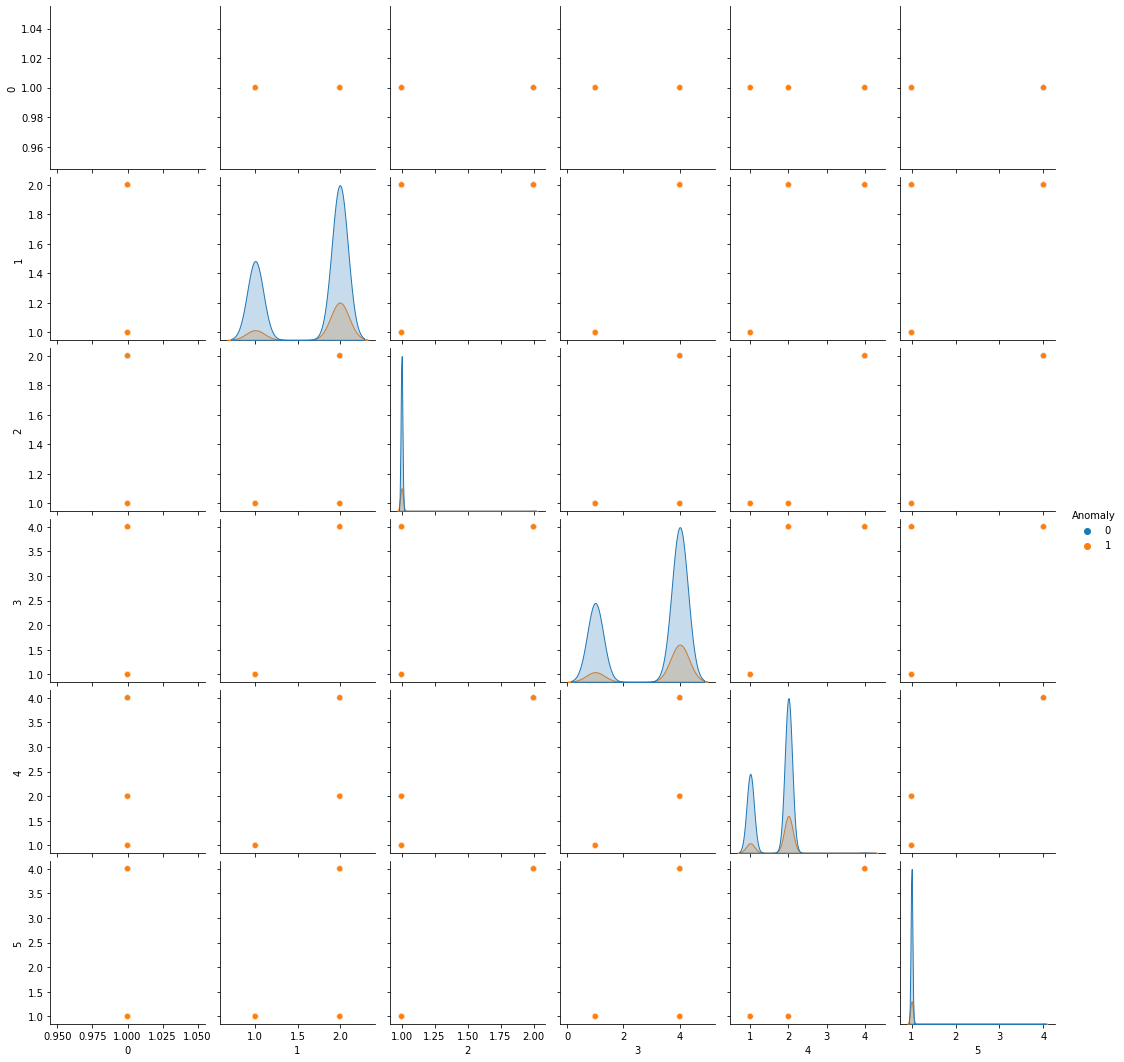

In [19]:
X_050_poly = pd.concat([pd.DataFrame(PolynomialFeatures(2).fit_transform(X.filter(like='OP050'))), y['Anomaly']], axis=1)

sns.pairplot(pd.concat([X_050_poly[X_050_poly['Anomaly'] == 0].sample(n=3000).loc[:, list(range(0, X_050_poly.shape[1] - 1)) + ['Anomaly']], 
                        X_050_poly[X_050_poly['Anomaly'] == 1].loc[:, list(range(0, X_050_poly.shape[1] - 1)) + ['Anomaly']]], 
                        ), hue='Anomaly')
plt.show()

# II - Machine Learning Models

Our machine learning model is trained over $n$ data points as : $\{(x_i, y_i), i = 1,...,n\}$ such that $x_i \in \mathbb{R}^{p}$ and its corresponding label $y_i \in \{0, 1\}$.<br> 
We therefore place ourselves in a binary classification task and use as a performance measure the AUC ROC. <br>
The submission requirement for a given algorithm is a csv file that contains the prediction probability to which an observation belongs to the class labelled 1 so as anomalous.<br>
We will start by analyzing the performances of each algorithm without feature selection and feature engineering and then proceed with the one with the best AUC ROC score. <br>
In this report, we will go through supervised algorithms even though unsupervised approaches have been tested on the side but performed poorly.


We start by defining a common method that would evaluate all algorithms:

In [20]:
def plot_conf_matrix(y_test, y_pred):
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    
def plot_validation_curve(model, x_train, y_train):
    
    N, train_score, validation_score = learning_curve(model, x_train, y_train, cv = 3, train_sizes=np.linspace(0.2, 1, 10), scoring='roc_auc')
    
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, validation_score.mean(axis=1), label='validation_score')
    plt.legend()
    plt.title('Validation Curve')
    
    return validation_score


In [21]:
def evaluate(model, x_train, x_test, y_train, y_test):
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    print('Classification report:\n')
    print(classification_report(y_test, y_pred))
    

    plt.figure(figsize=(14, 4))
    
    plt.subplot(1, 2, 1)
    plot_conf_matrix(y_test, y_pred)
    
    plt.subplot(1, 2, 2)
    validation_auc_score = plot_validation_curve(model, x_train, y_train)
    
    plt.show()
    
    plot_roc_curve(model, x_test, y_test)
    plt.title('ROC Curve')
    plt.show()
    
    print("Validation set AUC ROC average score = ", sum(validation_auc_score.ravel())/len(validation_auc_score.ravel()))
    print("Test set AUC ROC score = ", roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]))


### Defining train and test sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y['Anomaly'], test_size=0.33, random_state=0)

### Logistic Regression

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      8875
           1       0.06      0.73      0.11       229

    accuracy                           0.71      9104
   macro avg       0.53      0.72      0.47      9104
weighted avg       0.97      0.71      0.81      9104



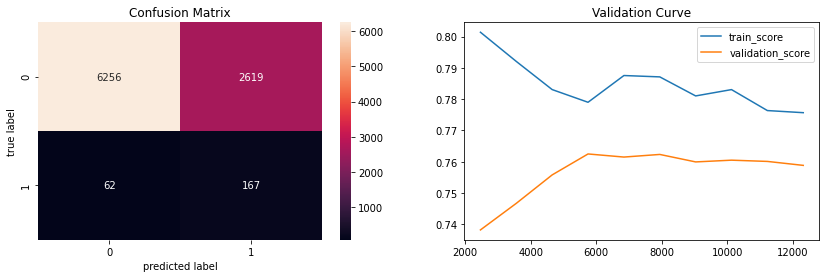

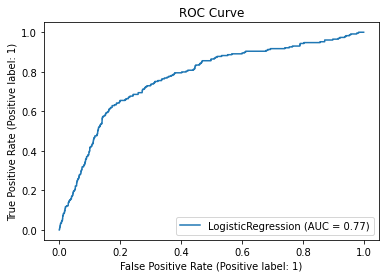

Validation set AUC ROC average score =  0.7566304614251826
Test set AUC ROC score =  0.7698780982840274


In [23]:
clf = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced')
evaluate(clf, X_train, X_test, y_train, y_test)

### KNN

Classification report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      8875
           1       0.00      0.00      0.00       229

    accuracy                           0.97      9104
   macro avg       0.49      0.50      0.49      9104
weighted avg       0.95      0.97      0.96      9104



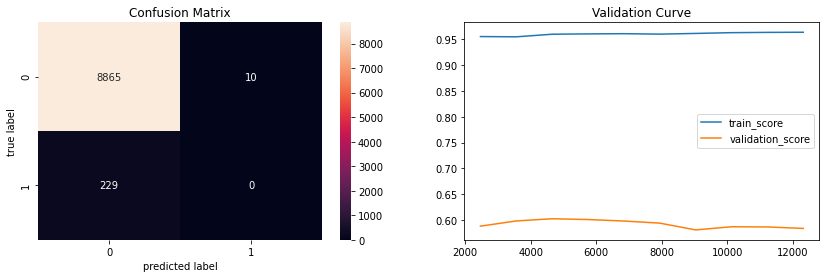

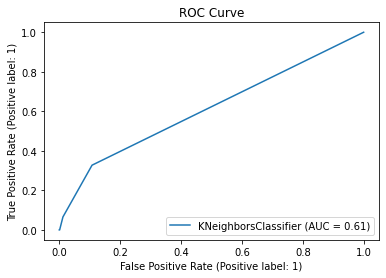

Validation set AUC ROC average score =  0.5923344976486997
Test set AUC ROC score =  0.6114841011132296


In [24]:
clf = KNeighborsClassifier(n_neighbors=5)
evaluate(clf, X_train, X_test, y_train, y_test)

The KNN algorithm does not perform well at its AUC ROC shows that it has no capacity to distinguish normal observations from anomalous ones. In fact, as we saw on the plots from the first part, (even though they are not representative of all 27 dimensions), the anomalous points lie within normal samples so nearest neighbors on a test observation has as many chances of being classified as anomalous than normal. Moreover in this example we used n = 5 neighbours but if we used more, we would have a much bigger chance of predicting a new observation as normal due to the unbalanced dataset and the inherent "voting" functionality in the algorithm. On another note, given the Validation Curve plot shown above, we can see that the model clearly overfit and increasing the number of samples did not improve predictions.

### Random Forest

Random forest is a powerful and efficient ensemble learning algorithm using several decision trees to make a prediction. In order to reduce overfitting, the max_depth parameter has been set to 6.

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      8875
           1       0.10      0.65      0.18       229

    accuracy                           0.85      9104
   macro avg       0.55      0.75      0.55      9104
weighted avg       0.97      0.85      0.90      9104



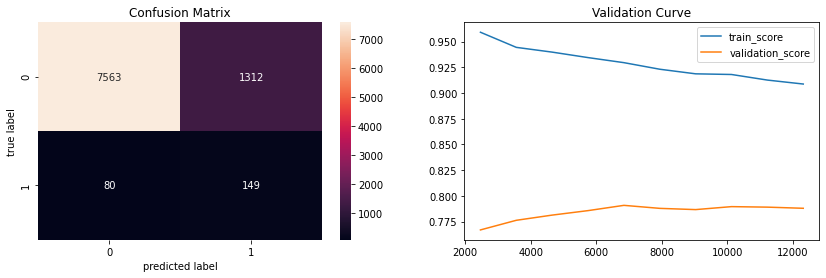

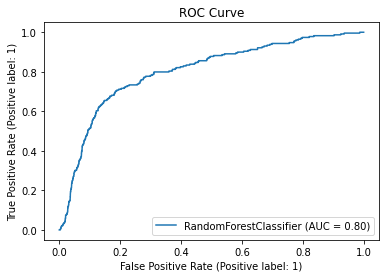

Validation set AUC ROC average score =  0.7842233133435479
Test set AUC ROC score =  0.8019745371794083


In [25]:
clf = RandomForestClassifier(criterion='entropy', class_weight='balanced', n_estimators=100, random_state=43, max_depth=6)
evaluate(clf, X_train, X_test, y_train, y_test)

Random forest is the best algorithm and is the one I have chosen to optimize and use for the submission.

Other algorithms that have been tested are SVM and unsupervised algorithms such as GMM, LOF and Isolation Forests which performed poorly.

## III - Feature Selection and Feature Engineering for Random Forest

Let's see if by reducing the number of features and choosing the most relevant ones, we can perform better with the Random Forest.

#### Using Selectkbest method from sklearn with an ANOVA test

In [26]:
k_best = SelectKBest(f_classif, k=7)
k_best.fit(X, y['Anomaly'])
k_cols = k_best.get_support(indices=True)
k_cols = X.columns[k_cols]
print('The selected columns are:', list(k_cols))

The selected columns are: ['START2_OP040_Vision_cosseprog', 'START2_OP080_Vision_rondelleprog', 'START2_OP090_SnapRingPeakForce', 'START2_OP100_Capuchon_insertionmesure', 'START2_OP110_Vissage_M8prog', 'START2_OP110_Vissage_M8torque', 'START2_OP120_RodageU_mesure']


Classification report:

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      8875
           1       0.09      0.64      0.16       229

    accuracy                           0.84      9104
   macro avg       0.54      0.74      0.54      9104
weighted avg       0.97      0.84      0.89      9104



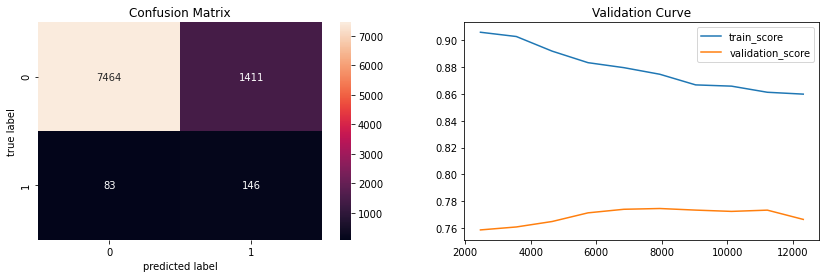

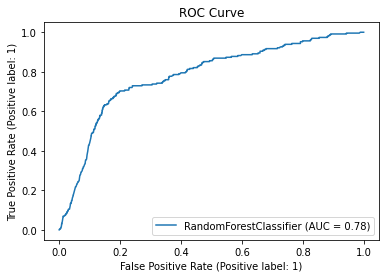

Validation set AUC ROC average score =  0.7690478557424514
Test set AUC ROC score =  0.7785238944584538


In [27]:
clf = RandomForestClassifier(criterion='entropy', class_weight='balanced', n_estimators=100, random_state=43, max_depth=6)
evaluate(clf, X_train[k_cols], X_test[k_cols], y_train, y_test)

The SelectKbest method did not improve the AUC score.

#### Using handpicked features by visualization of pairplots of both continuous and categorical features

I have chosen the following features based solely on visualizing the feature distributions that are most different for anomalous observations compared to normal ones.

In [28]:
filtered_categorical_features = ['START2_OP040_Vision_cosseprog', 'START2_OP080_Vision_rondelleprog', 'START2_OP100_Capuchon_insertionmesure']
filtered_continuous_features = ['START2_OP090_SnapRingFinalStroke', 'START2_OP090_SnapRingMidPointForce', 'START2_OP090_StartLinePeakForce', 'START2_OP120_RodageI_mesure']

filtered_columns = filtered_continuous_features + filtered_categorical_features

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      8875
           1       0.11      0.65      0.18       229

    accuracy                           0.86      9104
   macro avg       0.55      0.75      0.55      9104
weighted avg       0.97      0.86      0.90      9104



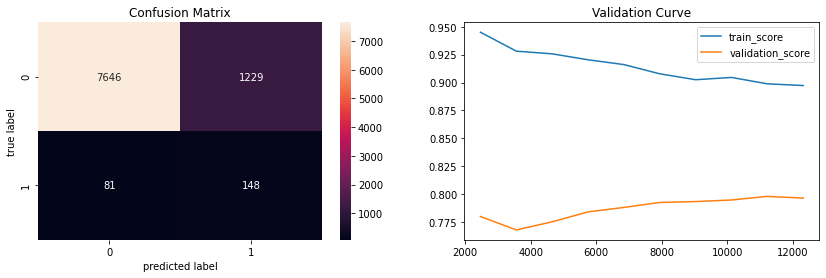

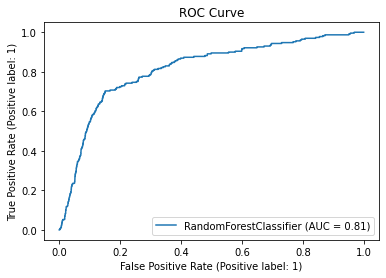

Validation set AUC ROC average score =  0.7870913917112072
Test set AUC ROC score =  0.8136426594501507


In [29]:
clf = RandomForestClassifier(criterion='entropy', class_weight='balanced', n_estimators=100, random_state=43, max_depth=6)
evaluate(clf, X_train[filtered_columns], X_test[filtered_columns], y_train, y_test)

The chosen features slightly improved the predictions after several trials and will therefore be used for the next part.

#### Using the information from duplicate values

As mentioned previously, we have seen that half of anomalous observations are duplicated. In fact, this information can be used for the random forest algorithm to make better predictions.

We therefore create a column called 'duplicated' that contains a value of 1 if an observation is duplicated and a 0 otherwise.

In [30]:
X_copy = X.copy()
X_copy.loc[X_copy[X_copy.duplicated(keep=False)].index, 'duplicated'] = 1
X_copy.loc[:, 'duplicated'] = X_copy['duplicated'].fillna(0)

In [31]:
X_copy[y['Anomaly'] == 1]['duplicated'].value_counts()

0.0    370
1.0    323
Name: duplicated, dtype: int64

We can see again here that 323 anomalies are duplicated rows.

Retraining the Random Forest classifier:

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_copy[filtered_columns + ['duplicated']], y['Anomaly'], test_size=0.33, random_state=0)

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      8875
           1       0.15      0.74      0.25       229

    accuracy                           0.89      9104
   macro avg       0.57      0.82      0.59      9104
weighted avg       0.97      0.89      0.92      9104



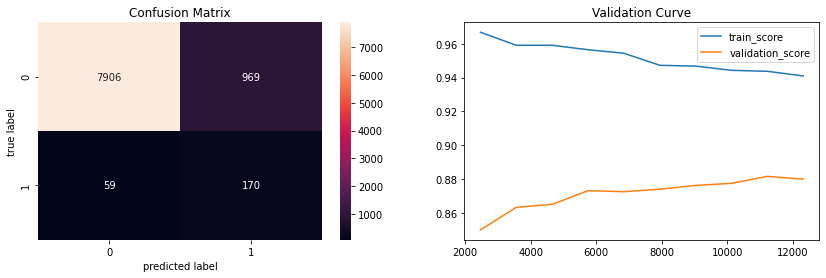

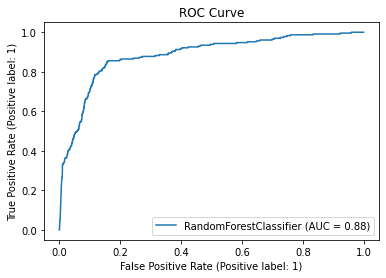

Validation set AUC ROC average score =  0.87128229727727
Test set AUC ROC score =  0.8838514053754842


In [33]:
clf = RandomForestClassifier(criterion='entropy', class_weight='balanced', n_estimators=100, random_state=43, max_depth=6)
evaluate(clf, X_train, X_test, y_train, y_test)

## Conclusion

As a conclusion, we have seen that anomalous observations were hardly distinguishable from normal ones as they lied within the same clusters even after trying different approaches to separate them. Afterwards, we saw that the best performing algorithm was the random forest classifier with which we selected specific features to get the best possible results, most importantly by using the fact that half of anomalous observations were duplicated.

### ---------------------------------------------------------------------------------------